In [2]:
# imports
import pandas as pd
import os
import calendar
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
df_lalonde = pd.read_csv('lalonde.csv').set_index('id')
df_lalonde.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [4]:
sns.set(color_codes=True)

# Question 1: Propensity score matching

### 1. A naive analysis
By looking at the data a  naive "researcher" might conclude that people who took part in the job training are more suceptible to earn more money in 1778 after the training

,treated,control
count,185.000000,429.000000
mean,6349.143530,6984.169742
std,7867.402218,7294.161791
min,0.000000,0.000000
25%,485.229800,220.181300
50%,4232.309000,4975.505000
75%,9642.999000,11688.820000
max,60307.930000,25564.670000


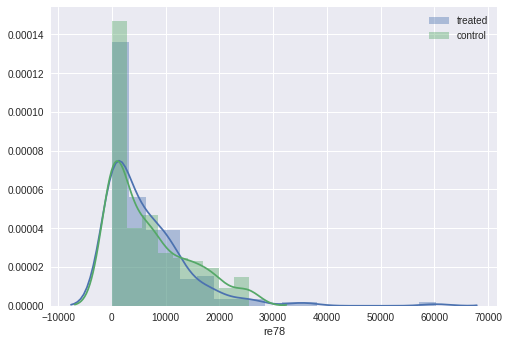

In [5]:
df_lalonde_treated = df_lalonde[df_lalonde.treat == 1]
df_lalonde_control = df_lalonde[df_lalonde.treat == 0]

#does a distplot makes sense in this situation (maybe an histogram would be better)
sns.distplot(df_lalonde_treated["re78"], label="treated")
sns.distplot(df_lalonde_control["re78"], label="control")
plt.legend()
df_summary = pd.DataFrame()
df_summary["treated"] = df_lalonde_treated["re78"].describe()
df_summary["control"] = df_lalonde_control["re78"].describe()
df_summary

### 2. A closer look at the data

In [13]:
def compare_feature(df,feature, ax=None):
    df_treated = df[df.treat == 1]
    df_control = df[df.treat == 0]
    sns.distplot(df_lalonde_treated[feature], label="treated", ax=ax)
    sns.distplot(df_lalonde_control[feature], label="control", ax=ax)
    plt.legend()
    df_summary = pd.DataFrame()
    df_summary[(feature, "treated")] = df_lalonde_treated[feature].describe()
    df_summary[(feature, "control")] = df_lalonde_control[feature].describe()
    df_summary.columns = pd.MultiIndex.from_tuples([(feature,'treated'),(feature,'control')], names=['feature', 'treat'])
    return df_summary

feature         age                    educ                   black  \
treat       treated     control     treated     control     treated   
count    185.000000  429.000000  185.000000  429.000000  185.000000   
mean      25.816216   28.030303   10.345946   10.235431    0.843243   
std        7.155019   10.786653    2.010650    2.855238    0.364558   
min       17.000000   16.000000    4.000000    0.000000    0.000000   
25%       20.000000   19.000000    9.000000    9.000000    1.000000   
50%       25.000000   25.000000   11.000000   11.000000    1.000000   
75%       29.000000   35.000000   12.000000   12.000000    1.000000   
max       48.000000   55.000000   16.000000   18.000000    1.000000   

feature                  hispan                 married              \
treat       control     treated     control     treated     control   
count    429.000000  185.000000  429.000000  185.000000  429.000000   
mean       0.202797    0.059459    0.142191    0.189189    0.512821   
std        0.402552    0.237124    0.349654    0.392722    0.500419   
min        0.000000    0.000000    0.000000    0.000000    0.000000   
25%        0.000000    0.000000    0.000000    0.000000    0.000000   
50%        0.000000    0.000000    0.000000    0.000000    1.000000   
75%        0.000000    0.000000    0.000000    0.000000    1.000000   
max        1.000000    1.000000    1.000000    1.000000    1.000000   

feature    nodegree                      re74                        re75  \
treat       treated     control       treated       control       treated   
count    185.000000  429.000000    185.000000    429.000000    185.000000   
mean       0.708108    0.596737   2095.573689   5619.236506   1532.055314   
std        0.455867    0.491126   4886.620353   6788.750796   3219.250870   
min        0.000000    0.000000      0.000000      0.000000      0.000000   
25%        0.000000    0.000000      0.000000      0.000000      0.000000   
50%        1.000000    1.000000      0.000000   2547.047000      0.000000   
75%        1.000000    1.000000   1291.468000   9277.128000   1817.284000   
max        1.000000    1.000000  35040.070000  25862.320000  25142.240000   

feature                        re78                
treat         control       treated       control  
count      429.000000    185.000000    429.000000  
mean      2466.484443   6349.143530   6984.169742  
std       3291.996183   7867.402218   7294.161791  
min          0.000000      0.000000      0.000000  
25%          0.000000    485.229800    220.181300  
50%       1086.726000   4232.309000   4975.505000  
75%       3881.419000   9642.999000  11688.820000  
max      18347.230000  60307.930000  25564.670000

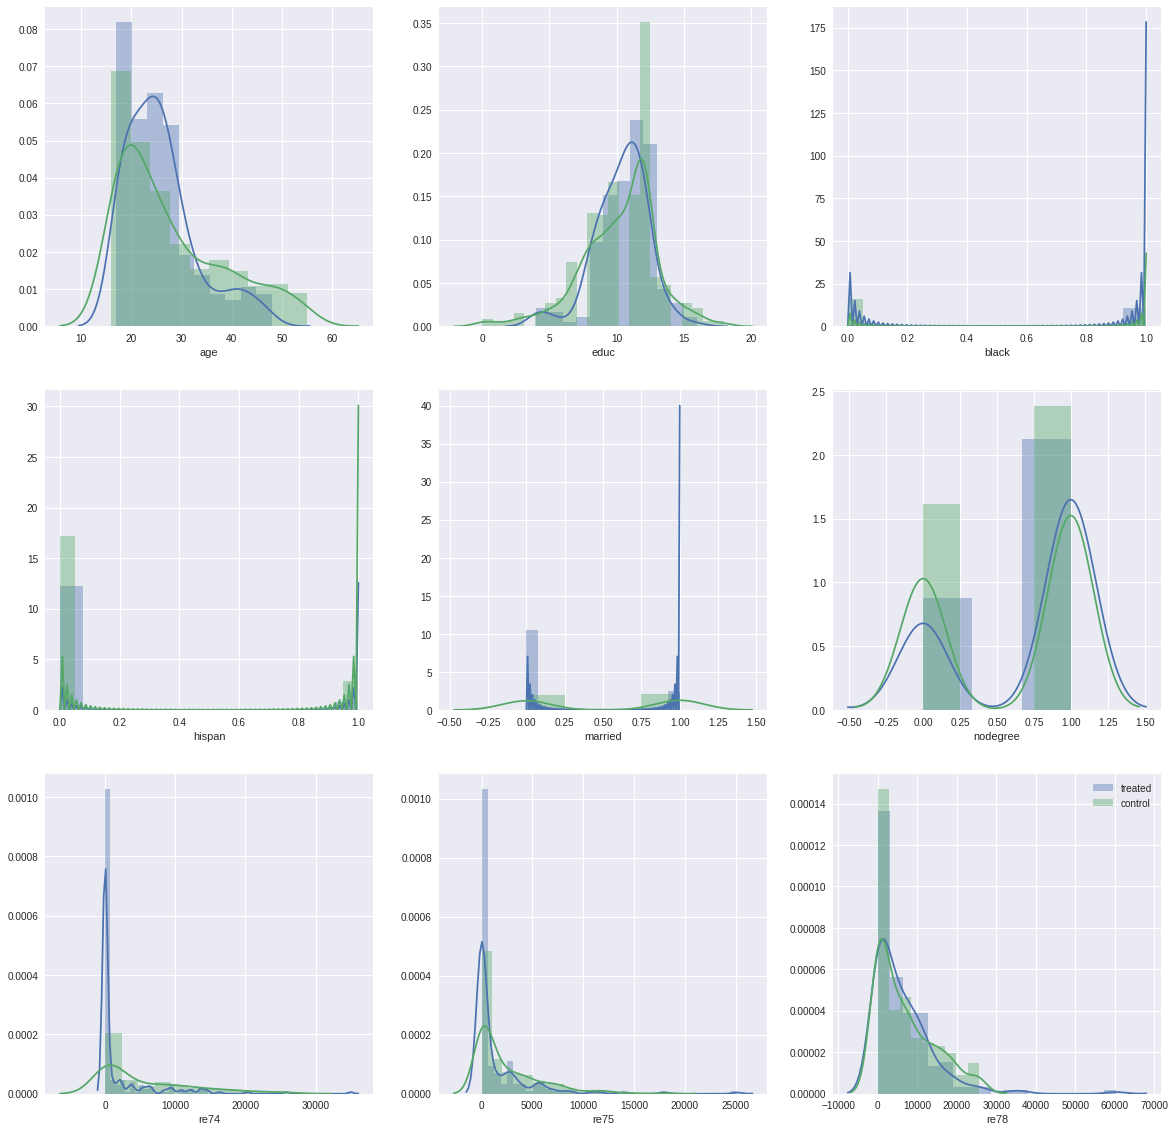

In [29]:
features = list(df_lalonde.columns)
features.remove('treat')
df_all_summary = pd.DataFrame()
fig, axes = plt.subplots(3,3, figsize=(20,20))
for i, f in enumerate(features):
    df = compare_feature(df_lalonde, f, axes[int(i/3), i%3])
    df_all_summary = pd.concat([df_all_summary, df], axis=1)
df_all_summary